| **Chapter**                   | 9:  Agent-based models             |
| ----------------------------- |------------------------------------|
| **Computational Note**        | 9.x: SEIRD with quarantine         |
| **Package prerequisites**     | [Mesa](http://mesa.readthedocs.io) |

# SEIRD with quarantine


In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from mesa import batchrunner
from matplotlib import pyplot as plt
from matplotlib import colors as clrs
import networkx as nx
import json
from scipy import stats
import enum


COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p mesa

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

mesa: 0.9.0

json      : 2.0.9
networkx  : 2.8.4
numpy     : 1.21.6
matplotlib: 3.5.2
mesa      : 0.9.0
pandas    : 1.4.2
scipy     : 1.8.1



In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    SYMPTOMATIC = 2
    RECOVERED = 3
    DECEASED = 4
    QUARANTINED = 5

In [4]:
class Person(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        
        # Naive start
        self.state = State.SUSCEPTIBLE
        self.days_remaining_of_quarantine = None
        
    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) 
                                                                            if agent.state is State.SUSCEPTIBLE]

        for neighbour in susceptible_neighbourhood:
            if self.state in [State.SYMPTOMATIC, State.EXPOSED] and np.random.rand() < self.model.beta:
                neighbour.state = State.EXPOSED

    def status_update(self):        
        if self.state == State.SYMPTOMATIC:
            if np.random.rand() < 1/self.model.recovery_period:
                if np.random.rand() < self.model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED
            elif np.random.rand() < self.model.quarantine_capture_fraction:
                self.state = State.QUARANTINED
                self.days_remaining_of_quarantine = self.model.quarantine_length + 1
        
        if self.state == State.EXPOSED:
            if np.random.rand() < 1/self.model.latency_period:
                self.state = State.SYMPTOMATIC

        if self.state == State.QUARANTINED:
            self.days_remaining_of_quarantine -= 1
            if self.days_remaining_of_quarantine < 1:
                self.state = State.RECOVERED
                self.days_remaining_of_quarantine = None

        if np.random.rand() < self.model.base_mortality_rate:
            self.state = State.DECEASED


    def step(self):
        self.status_update()

        if self.state in [State.SYMPTOMATIC, State.EXPOSED]:
            self.contact_event()
    

In [5]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 nodes=5000, 
                 mean_degree=12,
                 recovery_period=7,
                 latency_period=4,
                 beta=0.0075,
                 CFR=0.05,
                 base_mortality_rate=0.000125,
                 quarantine_capture_fraction=0.1,
                 quarantine_length=7,
                 I0=0.05):
                     
        self.N_agents = nodes
        self.recovery_period = recovery_period
        self.latency_period = latency_period
        self.beta = beta
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate
        self.quarantine_capture_fraction = quarantine_capture_fraction
        self.quarantine_length = quarantine_length

        self.graph = nx.erdos_renyi_graph(n=self.N_agents, p=mean_degree/self.N_agents)
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True

        for idx, node in enumerate(self.graph.nodes()):
            agent = Person(uid=idx + 1, model=self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

            if np.random.rand() < I0:
                agent.state = State.EXPOSED

        self.datacollector = DataCollector(agent_reporters={"State": "state"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def to_df(self):
        state_profile = self.datacollector.get_agent_vars_dataframe()
        output_df = pd.pivot_table(state_profile.reset_index(), 
                       index="Step", 
                       columns="State", 
                       aggfunc=np.size, 
                       fill_value=0)
        output_df.columns = [i.title() for i in State.__dict__.get("_member_names_")]
        return output_df

In [6]:
br = batchrunner.FixedBatchRunner(NetworkInfectiousDiseaseModel,
                                  fixed_parameters={"nodes": 5000},
                                  iterations=32,
                                  max_steps=60,
                                  model_reporters={"vals": lambda m: m.datacollector},
                                  display_progress=True)

In [7]:
br.run_all()

32it [01:18,  2.45s/it]


In [8]:
results = [pd.pivot_table(i.get_agent_vars_dataframe().reset_index(), 
                    index="Step", 
                    columns="State", 
                    aggfunc=np.size, 
                    fill_value=0).rename(columns={0: "Susceptible",
                                                  1: "Exposed",
                                                  2: "Symptomatic",
                                                  3: "Recovered",
                                                  4: "Deceased",
                                                  5: "Quarantined"}).droplevel(0, axis=1) for i in br.get_model_vars_dataframe().vals]

In [9]:
means = pd.concat([each.stack() for each in results], axis=1).apply(lambda x: x.mean(), axis=1).unstack()
sds = pd.concat([each.stack() for each in results], axis=1).apply(lambda x: x.std(), axis=1).unstack()

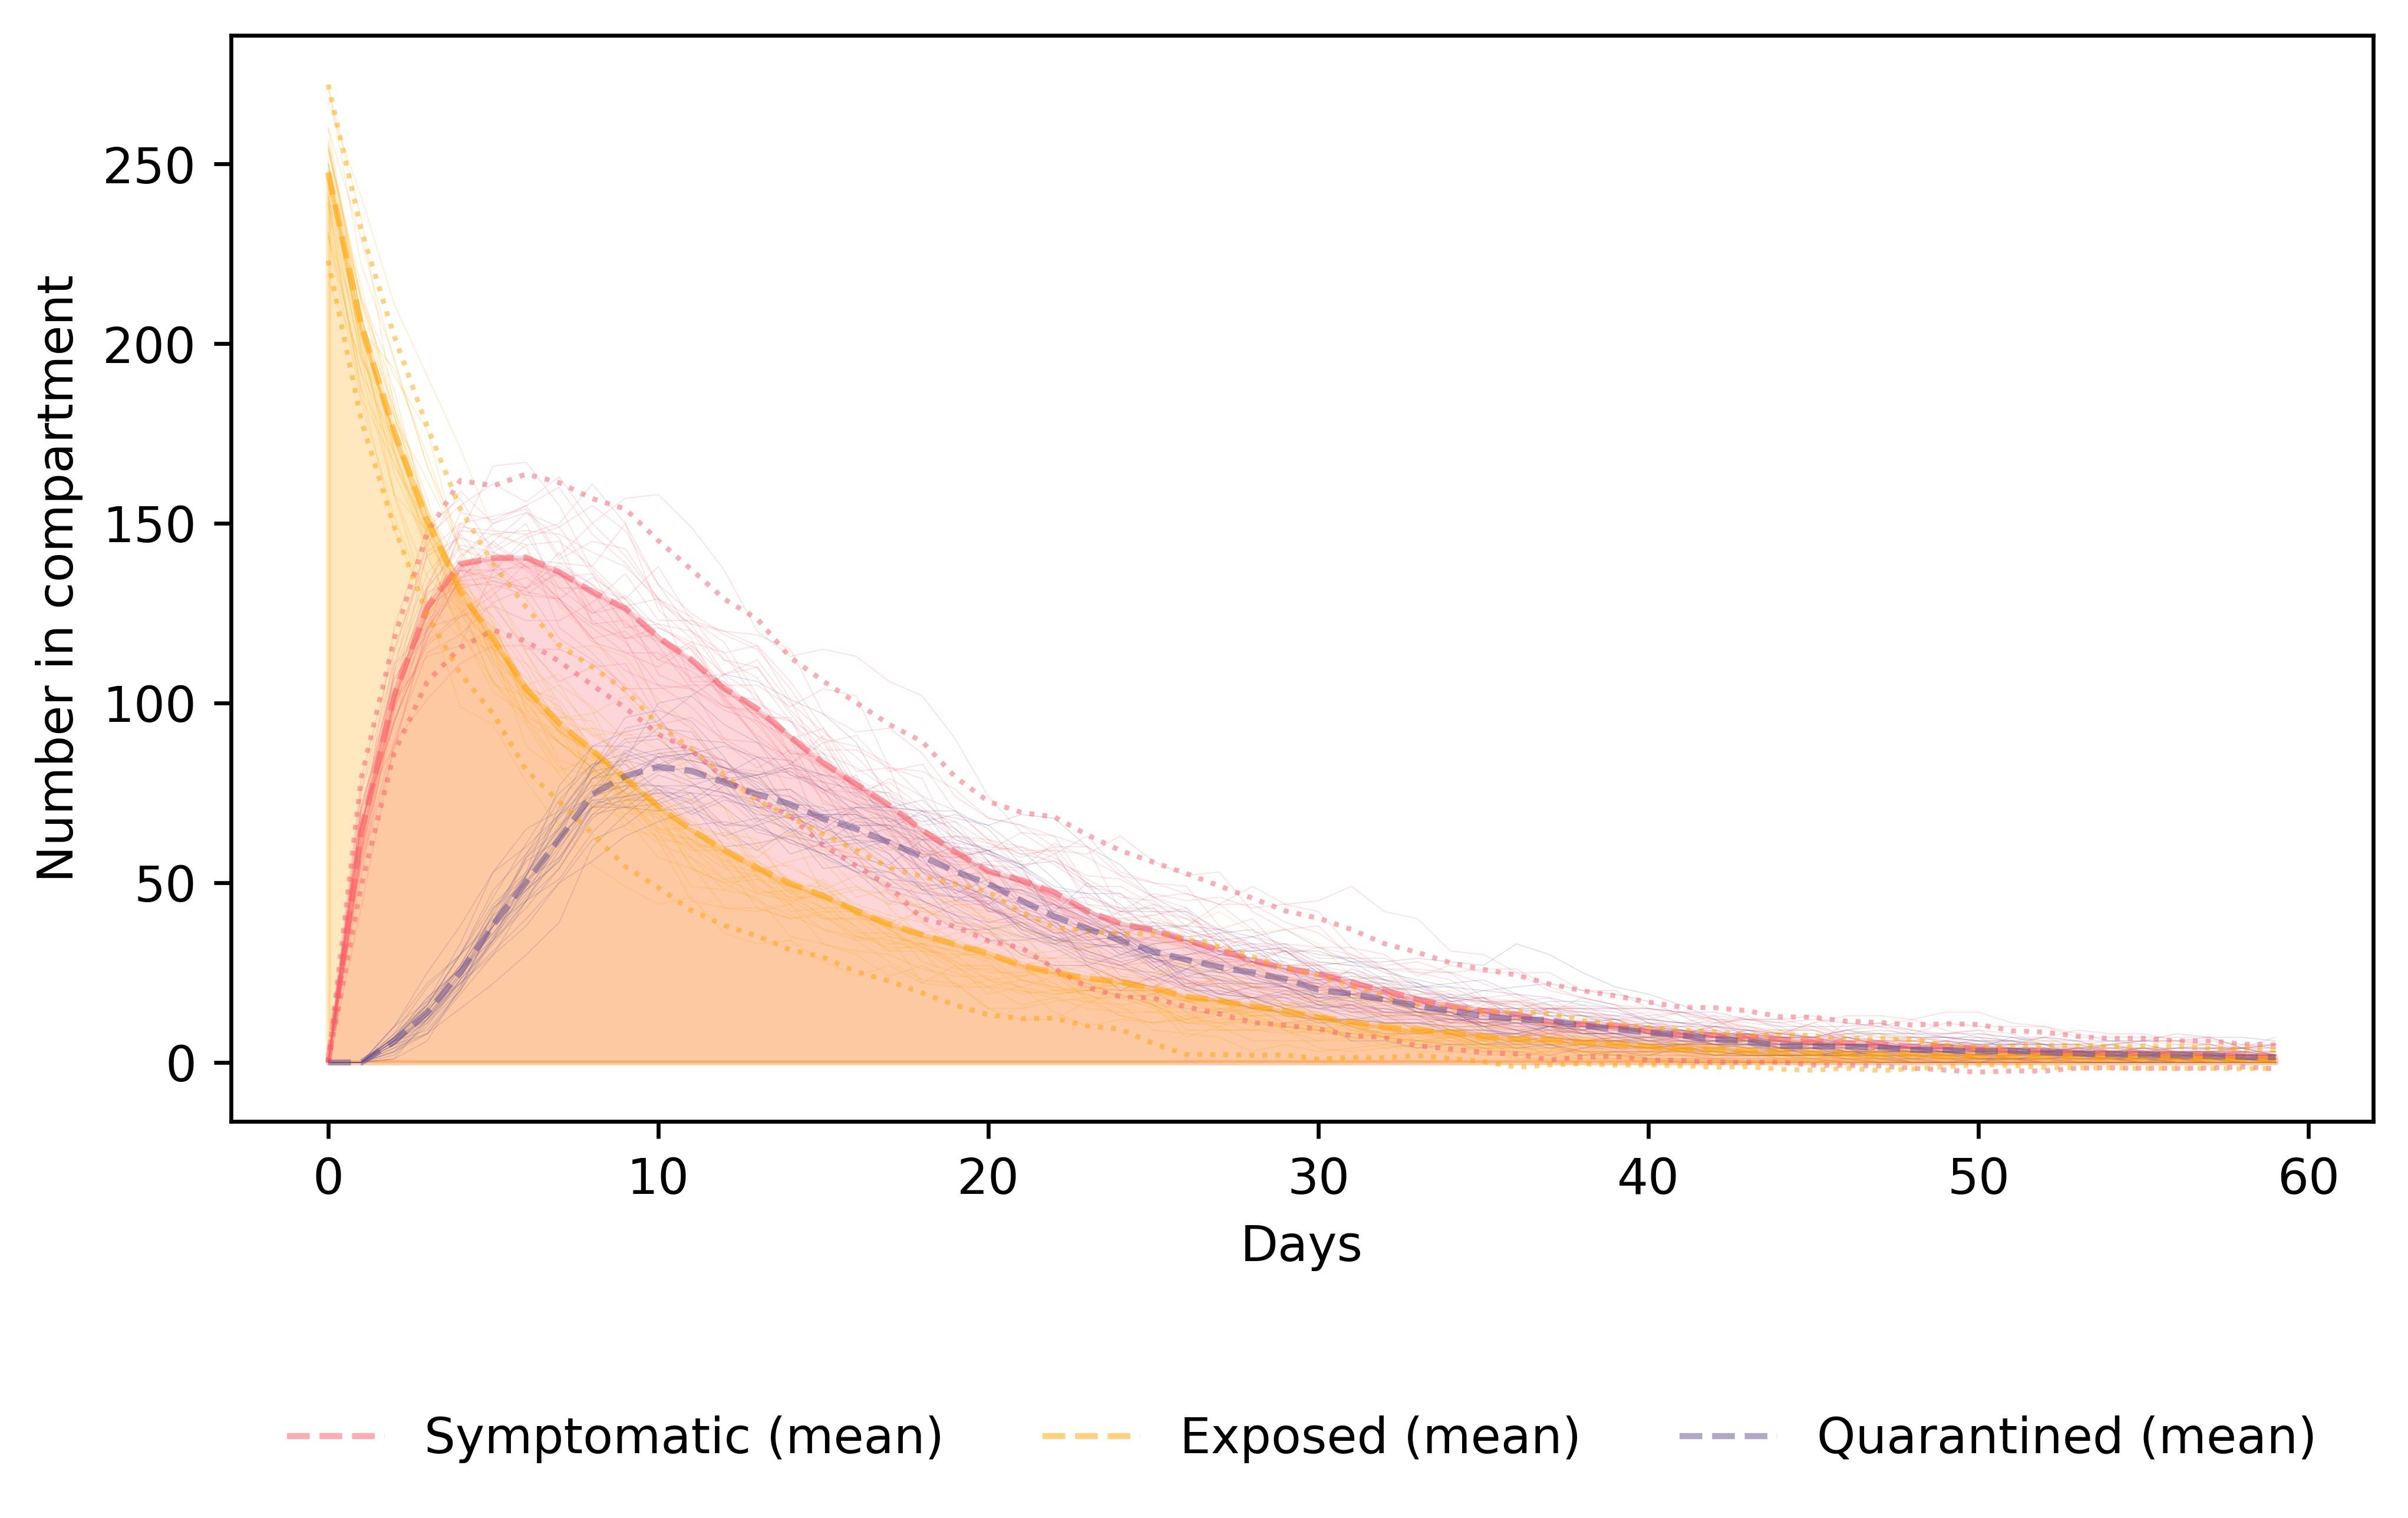

In [10]:
fig = plt.figure(facecolor="w", figsize=(8, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

for idx, model_results in enumerate(results):
    ax.plot(model_results.index, model_results.Symptomatic, color=COLORS["I"], alpha=0.2, lw=0.2, label="")
    ax.plot(model_results.index, model_results.Exposed, color=COLORS["E"], alpha=0.2, lw=0.2, label="")
    ax.plot(model_results.index, model_results.Quarantined, color=COLORS["X"], alpha=0.2, lw=0.2, label="")


ax.plot(means.index, means.Symptomatic, color=COLORS["I"], alpha=0.5, lw=1.25, linestyle="--", label="Symptomatic (mean)")
ax.plot(means.index, means.Symptomatic + 1.96 * sds.Symptomatic, color=COLORS["I"], alpha=0.5, lw=1, linestyle=":")
ax.plot(means.index, means.Symptomatic - 1.96 * sds.Symptomatic, color=COLORS["I"], alpha=0.5, lw=1, linestyle=":")
ax.fill_between(means.index, means.Symptomatic, color=COLORS["I"], alpha=0.25)

ax.plot(means.index, means.Exposed, color=COLORS["E"], alpha=0.5, lw=1.25, linestyle="--", label="Exposed (mean)")
ax.plot(means.index, means.Exposed + 1.96 * sds.Exposed, color=COLORS["E"], alpha=0.5, lw=1, linestyle=":")
ax.plot(means.index, means.Exposed - 1.96 * sds.Exposed, color=COLORS["E"], alpha=0.5, lw=1, linestyle=":")
ax.fill_between(means.index, means.Exposed, color=COLORS["E"], alpha=0.25)

ax.plot(means.index, means.Quarantined, color=COLORS["X"], alpha=0.5, lw=1.25, linestyle="--", label="Quarantined (mean)")


legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title="", bbox_to_anchor=(0.5, -0.355), loc="lower center", ncol=3, frameon=False)

ax.set_xlabel("Days")
ax.set_ylabel("Number in compartment")

fig.tight_layout(pad=5.0)
plt.savefig("SEIRDQ_ABM_output.pdf")